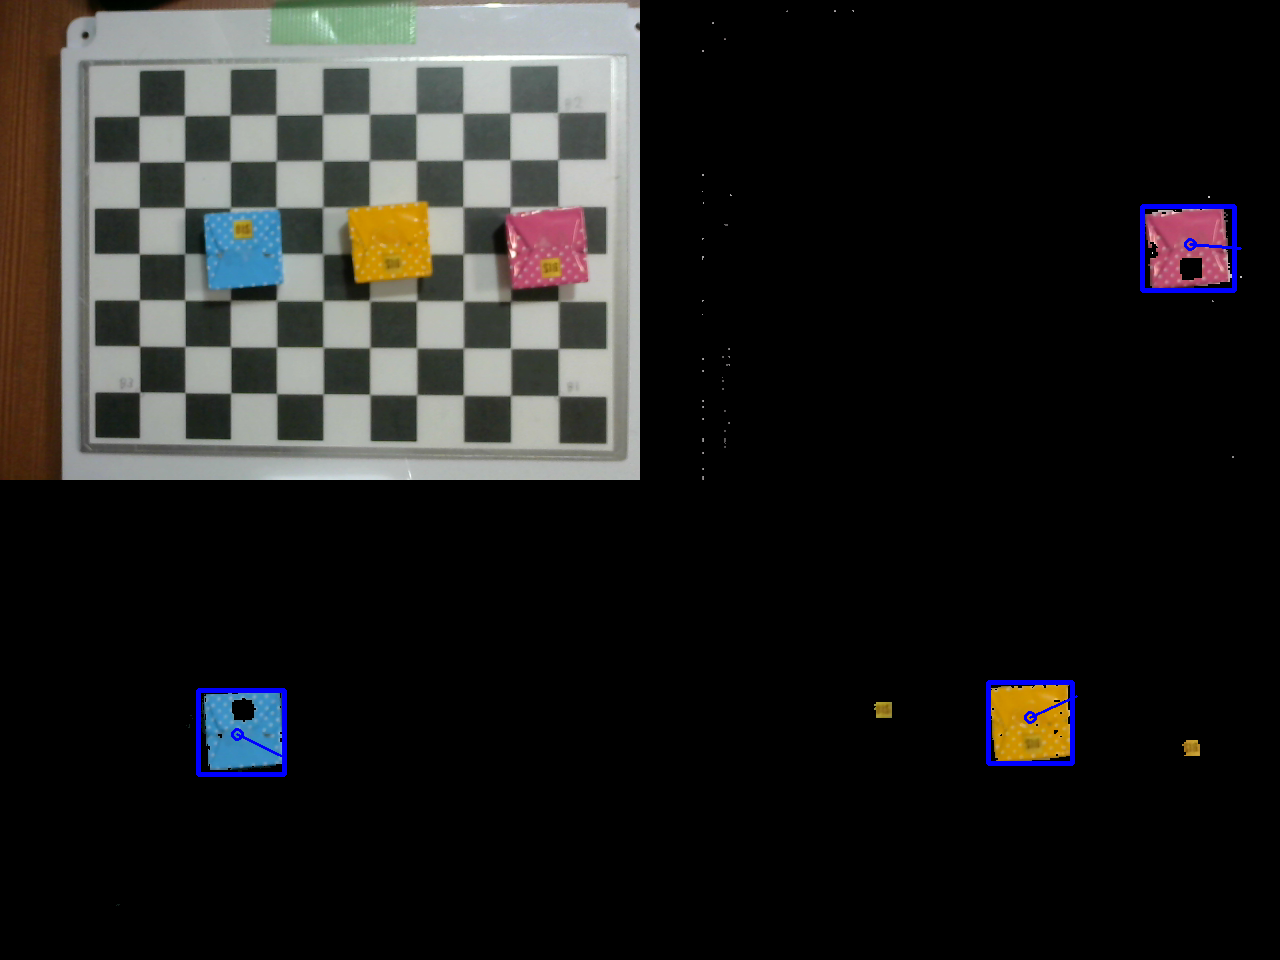

In [19]:
# -*- coding:utf-8 -*-

#
# (4) 画像処理（色抽出）およびロボットの制御を行うプログラム
#

import cv2
from time import sleep
import numpy as np
import math
import socket
from IPython.display import display, Image

def display_cv_image(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))
    
def capture_camera(camid=0, mirror=True, size=None):
    """Capture video from camera"""
    # カメラをキャプチャする
    cap = cv2.VideoCapture(camid) # 0はカメラのデバイス番号
    frameIdx = 0
    while True:
        # retは画像を取得成功フラグ
        ret, frame = cap.read()

        # 鏡のように映るか否か
        if mirror is True:
            frame = frame[:,::-1]

        # フレームをリサイズ
        # sizeは例えば(800, 600)
        if size is not None and len(size) == 2:
            frame = cv2.resize(frame, size)

        # フレームを表示する
        #cv2.imshow('camera capture', frame)

        k = cv2.waitKey(1) # 1msec待つ
        if k == 27: # ESCキーで終了
            break
        
        if frameIdx > 30: # ESCキーで終了
            cv2.imwrite('camera.png', frame)
            break
        
            
        frameIdx = frameIdx + 1
        
    # キャプチャを解放する
    cap.release()
    #cv2.destroyAllWindows()

def ContoursFromImage(image):
    
    #image, contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def find_rect_of_target_color(image):
    contours = ContoursFromImage(image)
    rects = []
    for contour in contours:
        approx = cv2.convexHull(contour)
        rect = cv2.boundingRect(approx)
        rects.append(np.array(rect))
        
    return rects

def extractcolorHSV(img):
    # 取得する色の範囲を指定する
    '''
    lower_blue = np.array([80, 100, 20])
    upper_blue = np.array([180, 255, 255])

    lower_red = np.array([0, 128, 0])
    upper_red = np.array([10, 255, 255])

    lower_yellow = np.array([20, 120, 120])
    upper_yellow = np.array([80, 255, 255])
    '''
    
    # 取得する色の範囲を指定する
    lower_blue = np.array([80, 100, 0])
    upper_blue = np.array([120, 255, 255])

    lower_red = np.array([140, 0, 0])
    upper_red = np.array([180, 255, 255])

    lower_yellow = np.array([20, 120, 120])
    upper_yellow = np.array([80, 255, 255])
    
    # フレームをHSVに変換
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 指定した色に基づいたマスク画像の生成
    img_mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    img_mask_red = cv2.inRange(hsv, lower_red, upper_red)
    img_mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    
    return img_mask_red,img_mask_blue,img_mask_yellow

def getMaxRect(mask):
    #display_cv_image(srcimg, srcimgFilename)
    rect1 = find_rect_of_target_color(mask)
    
    #print(rect1)
    #面積最大を探す
    maxSq = 0
    maxSqIdx = 0
    idx = 0
    for rect in rect1:
        sq = rect[2]*rect[3]
        if(sq > maxSq):
            maxSq = sq
            maxSqIdx=idx
        idx=idx+1
        
    if(maxSq > 50):
        return rect1[maxSqIdx]
    else:
        return null

def getRotation(src):
    #image, contours, hierarchy = cv2.findContours(src, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours(src, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #print(contours)
    #print(contours[0])
    #rect2 = cv2.minAreaRect(contours[0]) 
    #print(rect2) 
    
    
    # 各輪郭に対する処理
    for i in range(0, len(contours)):
        # 輪郭の領域を計算
        area = cv2.contourArea(contours[i])

        # ノイズ（小さすぎる領域）と全体の輪郭（大きすぎる領域）を除外
        if area < 1e2 or 1e5 < area:
            continue

        # 輪郭を描画する
        cv2.drawContours(src, contours, i, (0, 0, 255), 2, 8, hierarchy, 0)

        # 輪郭データを浮動小数点型の配列に格納
        X = np.array(contours[i], dtype=np.float).reshape((contours[i].shape[0], contours[i].shape[2]))

        # PCA（１次元）
        mean, eigenvectors = cv2.PCACompute(X, mean=np.array([], dtype=np.float), maxComponents=1)

        # 主成分方向のベクトルを描画
        pt = (mean[0][0], mean[0][1])
        vec = (eigenvectors[0][0], eigenvectors[0][1])
        #drawAxis(src, pt, vec, (255, 255, 0), 150)
        #print(pt,vec)
        
        return pt,vec
    

def drawVec(img, pt, vec):
    # 終了点
    length = 50
    end_pt = (int(pt[0] + length * vec[0]), int(pt[1] + length * vec[1]))
    cv2.circle(img, (int(pt[0]), int(pt[1])), 5, (255,0,0), 2)
    cv2.line(img, (int(pt[0]), int(pt[1])), end_pt, (255,0,0), 2);
    
    return img


def ReadMat(filename):
    f = open(filename,'r')
    lines = f.readlines()
    f.close()
    
    mat = []
    for line in lines:
        line = line.replace('\r','').replace('\n','')
        items = line.split(',')
        row = []
        for j in items:
            row.append(float(j))
        mat.append(row)
        
    return mat
    
def Transform(RMat,tMat,imgPt):
    RMat = np.array(RMat)
    tMat = np.array(tMat)
    imgPt = np.array(imgPt)
    
    #print('RMat',RMat)
    #print('tMat',tMat)
    #print('imgPt',imgPt)
    
    robotPt = np.dot(RMat, imgPt) +tMat
    #print(robotPt)
    
    return robotPt

def RobotRef(command):
    return
    
    host = "127.0.0.1" #お使いのサーバーのホスト名を入れます
    port = 5000 #適当なPORTを指定してあげます
    client = socket.socket(socket.AF_INET, socket.SOCK_STREAM) #オブジェクトの作成をします
    client.connect((host, port)) #これでサーバーに接続します
    #client.send(b"J,-900,0,0,0,0,300\n") #適当なデータを送信します（届く側にわかるように）
    client.send(command) #適当なデータを送信します（届く側にわかるように）
    response = client.recv(4096) #適当な2の累乗にします（大きすぎるとダメ）

    print(response)
    
if __name__ == '__main__':
    srcimgFilename = 'camera.png'
    RobotRef(b"J,-900,0,0,0,0,300\n")
    
    capture_camera(camid=1, mirror=False)
    image = cv2.imread(srcimgFilename)
    #display_cv_image(image, srcimgFilename)
    
    srcimg = cv2.imread(srcimgFilename)
    
    #テスト
    '''
    A = np.array([[1, 2],[3, 4]])
    B = np.array([[5, 6], [7, 8]])
    C = A * B
    print(C)
    '''
    
    #並進・回転行列の読み込み
    scale = ReadMat('scale.csv')
    RMat = ReadMat('R.csv')
    tMat = ReadMat('t.csv')
    
    points = dict()
    
    #display_cv_image(image, srcimgFilename)
    mask1,mask2,mask3 = extractcolorHSV(srcimg)
    
    redImg = cv2.bitwise_and(srcimg, srcimg, mask=mask1)
    blueImg= cv2.bitwise_and(srcimg, srcimg, mask=mask2)
    yellowImg=cv2.bitwise_and(srcimg, srcimg, mask=mask3)
    # 入力画像から窓画像を切り取り
    #roi = img[y:y+h, x:x+w]    
    
    #赤領域の切り出し
    try:    
        rect = getMaxRect(mask1)
        cv2.rectangle(redImg, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 0, 0), 4)
        roi = mask1[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        pt,vec = getRotation(roi)
        pt = (pt[0]+rect[0], pt[1]+rect[1])
        redImg = drawVec(redImg, pt, vec)
        points['red'] = (pt,vec)
    except:
        #import traceback
        #traceback.print_exc()
        pass
    
    try:    
        #青領域の切り出し
        rect = getMaxRect(mask2)
        cv2.rectangle(blueImg, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 0, 0), 4)
        roi = mask2[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        pt,vec = getRotation(roi)
        pt = (pt[0]+rect[0], pt[1]+rect[1])
        blueImg = drawVec(blueImg, pt, vec)
        points['blue'] = (pt,vec)
    except:
        #import traceback
        #traceback.print_exc()
        pass
    
    try:    
        #黄領域の切り出し
        rect = getMaxRect(mask3)
        cv2.rectangle(yellowImg, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 0, 0), 4)
        roi = mask3[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        pt,vec = getRotation(roi)
        pt = (pt[0]+rect[0], pt[1]+rect[1])
        yellowImg = drawVec(yellowImg, pt, vec)
        points['yellow'] = (pt,vec)
    except:
        #import traceback
        #traceback.print_exc()
        pass
    
    '''
    #print(points)
    robotPts=[]
    for key, value in points.items():
        #print("key:", key, "-- value:", value )
        pt = value[0]
        vec = value[1]
        print("vec",vec)
        #r = [pt[0], pt[1], 1.0]
        #rp= [pt[0] + vec[0] , pt[1] + vec[1], 1.0]

        r = np.array([[pt[0]], [pt[1]], [1.0]])
        rp= np.array([[pt[0] + vec[0]] ,[pt[1] + vec[1]],[1.0]])
        
        rd = Transform(RMat,tMat, r)
        rpd = Transform(RMat,tMat, rp)
        #rd = np.dot(RMat, r)
        #rpd = np.dot(RMat, rp)
        print(rd)
        print(rpd)
        
        #angle = int(1800.0*Math.Atan2((r.Y - rp.Y), (r.X - rp.X))/Math.PI);
        #angle = int(1800.0*math.atan2((rd[1] - rpd[1]), (rd[0] - rpd[0]))/math.pi);
        angle = int(1800.0*math.atan2(vec[0], vec[1])/math.pi)
        
        if(angle > 900):
            angle = angle - 1800
        
        if (angle < -900):
            angle = angle + 1800   
            
        print(angle)
        p = np.array([[pt[0]],[pt[1]],[0.0]])
        p = scale[0]*p
        robotPts.append([Transform(RMat,tMat,p), angle])
    
    for item in robotPts:
        p = item[0]
        angle = item[1]
        #cmd = 'P,'+str(p[0][0])+','+str(p[1][0])+','+str(p[2][0])+',0.0,0.0,0.0,200\n'
        #cmd = 'P,'+str(p[0][0])+','+str(p[1][0])+',100.0,' +str(angle)+ ',+40.0,0.0,200\n'
        cmd = 'P,'+str(p[0][0])+','+str(p[1][0])+',100.0,0.0,30.0,0.0,200\n'
        print('cmd:',cmd)
        RobotRef(cmd.encode())
        sleep(3)
        
        
        #ハンド開く
        cmd = 'S,4,-350,200\n'
        print('cmd:',cmd)
        RobotRef(cmd.encode())
        
        ##ハンドの角度を合わせる
        #cmd = 'S,3,'+str(angle)+',200\n'
        #print('cmd:',cmd)
        #RobotRef(cmd.encode())
        #sleep(3)
        
        #下降
        cmd = 'S,2,-1200,200\n'
        print('cmd:',cmd)
        RobotRef(cmd.encode())
        sleep(3)
        
        #把持
        cmd = 'S,4,100,100\n'
        print('cmd:',cmd)
        RobotRef(cmd.encode())
        sleep(3)
        
        #上昇
        cmd = 'S,2,1500,200\n'
        print('cmd:',cmd)
        RobotRef(cmd.encode())
        sleep(3)
        
        RobotRef(b"J,900,0,0,0,0,300\n")
        sleep(3)
        
        #リリース
        cmd = 'S,4,-300,100\n'
        print('cmd:',cmd)
        RobotRef(cmd.encode())
        sleep(3)
        
    RobotRef(b"J,-900,0,0,0,0,300\n")
    sleep(3)
    '''
    
    #display_cv_image(srcimg, 'srcimg.png')
    #display_cv_image(redImg, 'mask1.png')
    #display_cv_image(blueImg, 'mask2.png')
    #display_cv_image(yellowImg, 'mask3.png')
    
    '''
    display_cv_image(mask1, 'mask1.png')
    display_cv_image(mask2, 'mask2.png')
    display_cv_image(mask3, 'mask3.png')
    '''
    
    img5 = cv2.vconcat([srcimg, blueImg])
    img6 = cv2.vconcat([redImg, yellowImg])
    img7 = cv2.hconcat([img5, img6])
    cv2.imwrite('output.jpg', img7)
    display_cv_image(img7, 'output.png')
    
